In [19]:
import arviz as az
import numpyro
from numpyro.infer import Predictive, log_likelihood
from numpyro.infer.svi import SVIState, SVIRunResult
from numpyro.infer.autoguide import AutoDelta
import jax
import jax.random as random
import jax.numpy as jnp
import pandas as pd
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
import pickle
import dill
import seaborn as sns
from numpyro.infer.autoguide import AutoGuide

# Add ../code to PYTHON_PATH
sys.path.insert(0, "../code")
sys.path.insert(0, "..")
import bnns.model_configs
from datasets.synthetic import SyntheticDataset
from datasets.uci import UCIDataset, dataset_names, load_standard_splits

In [20]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
jax.__version__

'0.5.0'

In [22]:
# Adjust as needed
SAMPLE_PATH = "../samples/2025-03-11T13:09:21.643492"
SAMPLE_PATH = os.path.join(SAMPLE_PATH, "SVI")
SEED = 10

# Load models

In [31]:
models = []
key = jax.random.PRNGKey(SEED)
dataset_keys = jax.random.split(key, len(os.listdir(SAMPLE_PATH)))
for key, dataset_name in zip(dataset_keys, os.listdir(SAMPLE_PATH)):
    if not os.path.isdir(os.path.join(SAMPLE_PATH, dataset_name)):
        continue
    model_keys = jax.random.split(key, len(os.listdir(os.path.join(SAMPLE_PATH, dataset_name))))
    if dataset_name in dataset_names:
        for key, file_name in zip(model_keys, os.listdir(os.path.join(SAMPLE_PATH, dataset_name))):
            if file_name[-7:] == ".pickle":
                model_key = key
                model_name = "_".join(file_name.split("_")[:-1])
                model = bnns.model_configs.__dict__[model_name]
                split_ind = int(file_name.split("_")[-1].split(".")[0])
                #az_data = az.from_netcdf(os.path.join(SAMPLE_PATH, dataset_name, file_name))
                with open(os.path.join(SAMPLE_PATH, dataset_name, file_name), "rb") as f:
                    svi_result: SVIRunResult = pickle.load(f)
                    models.append({"dataset": dataset_name, "model": model_name, "split": split_ind, "svi_result": svi_result})

# Load models from Ola's code instead

In [16]:

models = []
key = jax.random.PRNGKey(SEED)
dataset_keys = jax.random.split(key, len(os.listdir(SAMPLE_PATH)))
for key, dataset_name in zip(dataset_keys, os.listdir(SAMPLE_PATH)):
    if not os.path.isdir(os.path.join(SAMPLE_PATH, dataset_name)):
        continue
    model_keys = jax.random.split(key, len(os.listdir(os.path.join(SAMPLE_PATH, dataset_name))))
    if dataset_name in dataset_names:
        for key, file_name in zip(model_keys, os.listdir(os.path.join(SAMPLE_PATH, dataset_name))):
            if file_name[-5:] == ".dill":
                model_key = key
                model_name = "_".join(file_name.split("_")[:-1])
                model = bnns.model_configs.__dict__[model_name]
                split_ind = int(file_name.split("_")[-1].split(".")[0])
                #az_data = az.from_netcdf(os.path.join(SAMPLE_PATH, dataset_name, file_name))
                with open(os.path.join(SAMPLE_PATH, dataset_name, file_name), "rb") as f:
                    artifact = dill.load(f)
                    print(artifact)
                    models.append({"dataset": dataset_name, "model": model_name, "split": split_ind, "params": artifact["params"], "guide": artifact["guide"]})

{'model': <function model at 0x7f23d83444a0>, 'guide': <numpyro.infer.autoguide.AutoDelta object at 0x7f2357e0be30>, 'params': {'b0_auto_loc': Array([-0.01225611,  0.31583175,  0.23750882,  0.09215413,  0.32549813,
        0.3728021 ,  0.23324777,  0.08352895,  0.28529653,  0.2885003 ,
        0.28199393,  0.21611053,  0.43805328,  0.2733997 ,  0.00525672,
        0.14232388,  0.15198179,  0.45117712,  0.03465929, -0.5027374 ,
        0.1014718 ,  0.09114997,  0.09248329,  0.06091051,  0.04015032,
        0.26683372,  0.36052054,  0.19237721,  0.34335357,  0.25894952,
        0.39456132,  0.12241241,  0.28208202, -0.17152527,  0.21876141,
        0.42251503, -0.00625163,  0.35668573,  0.33573684,  0.29394758,
        0.23535271,  0.21160635,  0.25216237,  0.33548352,  0.18721652,
        0.26814017,  0.2668416 ,  0.06968401,  0.24410157,  0.3308951 ],      dtype=float32), 'b1_auto_loc': Array([ 0.05962995,  0.32242966,  0.10222967,  0.10607518,  0.06914018,
        0.03838382,  0.01837

# Evaluate RMSE

In [30]:
models[0]

{'dataset': 'boston-housing',
 'model': 'Ola_BNN',
 'split': 0,
 'params': {'b0_auto_loc': Array([ 0.33869344,  0.28251293,  0.28258768,  0.01094419,  0.31601626,
          0.24942532,  0.28880572,  0.13486034,  0.2333756 ,  0.3196657 ,
          0.18804452,  0.25520623,  0.26836118,  0.09495503,  0.1602012 ,
          0.08379555, -0.0584284 ,  0.4426236 ,  0.21965419, -0.27757534,
         -0.11508118,  0.4679596 ,  0.3840216 ,  0.4181929 ,  0.21701619,
          0.21648952,  0.26918277,  0.12111847,  0.22028948,  0.2591599 ,
          0.29395866, -0.00116551,  0.08897883,  0.3777143 ,  0.25058272,
          0.22303578,  0.20669924,  0.18414426,  0.13763784,  0.27533   ,
          0.15652096,  0.12304214,  0.34288546,  0.17698899,  0.34087998,
          0.41465616,  0.27061746,  0.3613547 , -0.09628877,  0.3131852 ],      dtype=float32),
  'b1_auto_loc': Array([ 0.2243842 ,  0.07997382,  0.07491369,  0.13335077,  0.101351  ,
         -0.18142737,  0.26269224,  0.08644305,  0.12469509,

In [6]:
# From Stein paper, probably more stable but should be equivalent
def nll_reg_fn(posterior_samples, model, x, y, batch_ndims):
    lls = log_likelihood(model, posterior_samples, X=x, y=y, D_Y=1, batch_ndims=batch_ndims)["y"]
    return -(jax.scipy.special.logsumexp(lls, axis=0) - jnp.log(lls.shape[0])).mean()

In [32]:

table = [{"dataset": x["dataset"], "model": x["model"], "split": x["split"]} for x in models]
model_key = random.PRNGKey(10)
for row, d in zip(models, table):

    model = bnns.model_configs.__dict__[d["model"]]
    print("model", model)

    dataset = UCIDataset(d["dataset"])
    splits = load_standard_splits(True)[d["dataset"]]
    svi_result = row["svi_result"]
    params = svi_result["params"]
    guide = svi_result["guide"]

    train_split = splits[d["split"]]["tr"]
    test_split = splits[d["split"]]["te"]
    X = dataset.normalize_X(dataset.data[:, :-1], splits[d["split"]])
    y = dataset.data[:,-1]
    train_X = X[train_split]
    train_y = y[train_split].flatten()
    test_X = X[test_split]
    test_y = y[test_split].flatten()

    mean  = train_X.mean(0)
    assert np.allclose(mean, 0, atol=1e-5)
    std = train_X.std(0)
    assert np.allclose(std, 1, atol=1e-5)
    assert np.allclose(test_X.mean(0), 0, atol=1), f"Mean: {test_X.mean(0)}"
    assert np.allclose(test_X.std(0), 1, atol=3), f"Std: {test_X.std(0)}"
    train_mean = dataset.data[:, :-1][train_split].mean(0)
    train_std = dataset.data[:, :-1][train_split].std(0)
    assert np.allclose(test_X * train_std + train_mean, dataset.data[:, :-1][test_split], atol=1e-3)

    predictive = Predictive(model, guide=guide, params=params, num_samples=10, return_sites=["y", "y_loc"], parallel=True, batch_ndims=0)
    predicted_ys = predictive(model_key, X=test_X, y=None, D_Y=1)["y_loc"]
    rmse = jnp.sqrt(((test_y - predicted_ys)**2).mean())
    d["rmse"] = rmse.mean()
    
    posterior_predictive = Predictive(guide, params=params, num_samples=1, batch_ndims=0)
    posterior_samples = posterior_predictive(model_key, X=train_X, y=train_y, D_Y=1)
    train_lls = -log_likelihood(model, posterior_samples, X=train_X, y=train_y, D_Y=1, batch_ndims=1)["y"]
    test_lls = -log_likelihood(model, posterior_samples, X=test_X, y=test_y, D_Y=1, batch_ndims=1)["y"]
    d["train_nll"] = f"{train_lls.mean() : .2f}±{train_lls.std() : .2f}"
    d["test_nll"] = f"{test_lls.mean() : .2f}±{test_lls.std() : .2f}"
pd.DataFrame(table)

model <function Ola_BNN at 0x7f23dc4ff560>
model <function Ola_BNN at 0x7f23dc4ff560>
model <function Ola_BNN at 0x7f23dc4ff560>
model <function Ola_BNN at 0x7f23dc4ff560>
model <function Ola_BNN at 0x7f23dc4ff560>
model <function Ola_BNN at 0x7f23dc4ff560>
model <function Ola_BNN at 0x7f23dc4ff560>
model <function Ola_BNN at 0x7f23dc4ff560>
model <function Ola_BNN at 0x7f23dc4ff560>
model <function Ola_BNN at 0x7f23dc4ff560>
model <function Ola_BNN at 0x7f23dc4ff560>
model <function Ola_BNN at 0x7f23dc4ff560>


,dataset,model,split,rmse,train_nll,test_nll
0,boston-housing,Ola_BNN,0,3.0634806,2.17± 1.70,2.95± 2.87
1,boston-housing,Ola_BNN,1,2.7014387,2.15± 1.92,2.57± 2.42
2,boston-housing,Ola_BNN,2,2.7735395,2.20± 2.12,2.70± 2.62
3,boston-housing,Ola_BNN,3,2.5403934,2.16± 1.81,2.45± 1.23
4,boston-housing,Ola_BNN,4,4.059718,2.08± 0.98,3.84± 7.66
5,boston-housing,Ola_BNN,5,2.1407466,2.22± 2.68,2.19± 0.92
6,boston-housing,Ola_BNN,6,2.0013747,2.25± 2.85,2.12± 0.80
7,boston-housing,Ola_BNN,7,3.0854623,2.14± 1.57,2.85± 2.80
8,boston-housing,Ola_BNN,8,3.837153,2.17± 1.63,3.83± 3.08
9,boston-housing,Ola_BNN,9,4.5604415,2.19± 2.65,5.02± 9.46


In [18]:
from bnns.rasmus_bnn import LATENT

table = [{"dataset": x["dataset"], "model": x["model"], "split": x["split"]} for x in models]
model_key = random.PRNGKey(10)
for row, d in zip(models, table):

    model = bnns.model_configs.__dict__[d["model"]]
    print("model", model)

    dataset = UCIDataset(d["dataset"])
    splits = load_standard_splits(True)[d["dataset"]]
    #svi_result: SVIRunResult = row["svi_result"]
    #params = svi_result.params
    #guide = AutoDelta(model)
    params = row["params"]
    guide = row["guide"]

    train_split = splits[d["split"]]["tr"]
    test_split = splits[d["split"]]["te"]
    X = dataset.normalize_X(dataset.data[:, :-1], splits[d["split"]])
    y = dataset.data[:,-1]
    train_X = X[train_split]
    train_y = y[train_split].flatten()
    test_X = X[test_split]
    test_y = y[test_split].flatten()

    mean  = train_X.mean(0)
    assert np.allclose(mean, 0, atol=1e-5)
    std = train_X.std(0)
    assert np.allclose(std, 1, atol=1e-5)
    assert np.allclose(test_X.mean(0), 0, atol=1), f"Mean: {test_X.mean(0)}"
    assert np.allclose(test_X.std(0), 1, atol=3), f"Std: {test_X.std(0)}"
    train_mean = dataset.data[:, :-1][train_split].mean(0)
    train_std = dataset.data[:, :-1][train_split].std(0)
    assert np.allclose(test_X * train_std + train_mean, dataset.data[:, :-1][test_split], atol=1e-3)

    model_key, model_key_ = random.split(model_key)
    # predictive = Predictive(model, guide=guide, params=params, num_samples=500, return_sites=["y", "y_loc"])
    # predicted_ys = predictive(model_key, X=test_X, y=None, D_Y=1)["y_loc"]
    # rmse = jnp.sqrt(((test_y - predicted_ys)**2).mean())
    # d["rmse"] = rmse.mean()
    
    # posterior_predictive = Predictive(guide, params=params, num_samples=1, batch_ndims=0)
    # posterior_samples = posterior_predictive(model_key, X=train_X, y=train_y, D_Y=1)
    model_key, model_key_ = random.split(model_key)
    #guide = AutoDelta(model)
    with jax.checking_leaks():
        posterior_sampler = Predictive(model, guide=guide, params=params, num_samples=500, return_sites=LATENT)
        posterior_samples = posterior_sampler(model_key_, X=train_X, y=train_y, D_Y=1) 
        train_lls = -log_likelihood(model, posterior_samples, X=train_X, y=train_y, D_Y=1, batch_ndims=1)["y"]
    test_lls = -log_likelihood(model, posterior_samples, X=test_X, y=test_y, D_Y=1, batch_ndims=1)["y"]
    d["train_nll"] = f"{train_lls.mean() : .2f}±{train_lls.std() : .2f}"
    d["test_nll"] = f"{test_lls.mean() : .2f}±{test_lls.std() : .2f}"
pd.DataFrame(table)

model <function Ola_BNN at 0x7f23dc4ff560>
model <function Ola_BNN at 0x7f23dc4ff560>
model <function Ola_BNN at 0x7f23dc4ff560>
model <function Ola_BNN at 0x7f23dc4ff560>
model <function Ola_BNN at 0x7f23dc4ff560>
model <function Ola_BNN at 0x7f23dc4ff560>
model <function Ola_BNN at 0x7f23dc4ff560>
model <function Ola_BNN at 0x7f23dc4ff560>
model <function Ola_BNN at 0x7f23dc4ff560>
model <function Ola_BNN at 0x7f23dc4ff560>
model <function Ola_BNN at 0x7f23dc4ff560>
model <function Ola_BNN at 0x7f23dc4ff560>
model <function Ola_BNN at 0x7f23dc4ff560>
model <function Ola_BNN at 0x7f23dc4ff560>
model <function Ola_BNN at 0x7f23dc4ff560>
model <function Ola_BNN at 0x7f23dc4ff560>
model <function Ola_BNN at 0x7f23dc4ff560>
model <function Ola_BNN at 0x7f23dc4ff560>


,dataset,model,split,train_nll,test_nll
0,boston-housing,Ola_BNN,0,2.02± 1.04,2.76± 2.75
1,boston-housing,Ola_BNN,1,2.00± 0.87,2.33± 1.96
2,boston-housing,Ola_BNN,2,1.99± 0.98,2.65± 2.15
3,boston-housing,Ola_BNN,3,2.01± 0.92,2.27± 0.91
4,boston-housing,Ola_BNN,4,1.95± 1.00,4.13± 8.90
5,boston-housing,Ola_BNN,5,2.08± 0.94,2.18± 0.75
6,boston-housing,Ola_BNN,6,2.01± 1.13,2.21± 0.89
7,boston-housing,Ola_BNN,7,1.96± 1.13,2.86± 2.88
8,boston-housing,Ola_BNN,8,1.99± 1.19,3.59± 3.09
9,boston-housing,Ola_BNN,9,2.06± 0.92,5.41± 12.72


In [19]:
test_X.shape

(51, 13)

In [11]:
pd.DataFrame(table).groupby(["dataset", "model"]).mean().reset_index()

TypeError: agg function failed [how->mean,dtype->object]

In [49]:
posterior_samples

{'b0': Array([[ 0.69854826,  0.18513954,  0.15191428,  0.2515047 , -0.42453936,
          1.0693603 ,  0.4549836 , -0.42092034, -0.18007399,  0.10867391,
          0.14760602,  0.09567831, -0.43617222,  0.05965615, -0.03736207,
         -0.09872007, -0.10381705, -0.0493153 , -0.09403294,  0.42793307,
          0.3070317 , -0.20986694, -0.19749999,  0.4083518 , -0.13500643,
         -0.58297175,  0.01004097,  0.23496032,  0.3743323 ,  0.38863435,
         -0.68328196, -0.44437346,  0.43196324,  0.00809771, -0.01975298,
         -0.1184203 , -0.27954847, -0.40059483,  0.04625546, -0.10012292,
          0.1687774 , -0.02018324,  0.2544373 , -0.33308715, -0.21285088,
          0.7325721 , -0.15511054,  0.44056305,  0.04307749,  0.37958434]],      dtype=float32),
 'b1': Array([[ 0.03172235,  0.09625729, -0.00308322,  0.08292691, -0.01292201,
          0.25426808,  0.00035041,  0.12073715, -0.24465138, -0.03105164,
          0.06382143,  0.09033161, -0.14013074, -0.17201155, -0.06660049,
   

In [29]:
svi_result.params["w0_auto_loc"]

Array([[-6.66631386e-02, -4.77252096e-01,  1.06691360e-01,
         3.30431871e-02, -6.84590936e-02, -7.84038186e-01,
         3.01249504e-01, -1.92659825e-01, -9.51841299e-04,
        -5.22353649e-01, -6.11785352e-01,  2.78839827e-01,
         4.34274733e-01,  2.74432935e-02,  1.22941621e-01,
        -7.85801113e-02,  1.59590825e-01, -4.96658355e-01,
        -6.61975920e-01, -1.30158693e-01, -4.28643733e-01,
         7.68024206e-01,  6.25389397e-01,  1.89518005e-01,
         2.95077235e-01, -1.25009596e-01, -2.84127086e-01,
        -2.29330257e-01,  4.71233159e-01,  1.87225997e-01,
         3.90324444e-01,  5.42739294e-02, -2.66391903e-01,
        -1.44099966e-01, -2.61314452e-01, -6.34123325e-01,
        -2.74519145e-01,  6.80536181e-02, -2.63673812e-01,
        -5.12354434e-01,  4.11475420e-01,  5.62263370e-01,
        -2.66182750e-01, -3.87046672e-02,  2.10926875e-01,
        -6.77690327e-01, -2.93276191e-01, -5.80262184e-01,
         4.11545455e-01,  1.87696174e-01],
       [ 5.83

In [39]:
def new_params(params):
    return {k: jnp.array([v]) for k, v in params.items()}

In [57]:
posterior_predictive(model_key, X=train_X, y=train_y, D_Y=1)

{}

In [47]:
from numpyro.handlers import substitute, trace
trace(substitute(model, new_params(svi_result.params))).get_trace(X=test_X, y=test_y, D_Y=1)

AssertionError: 

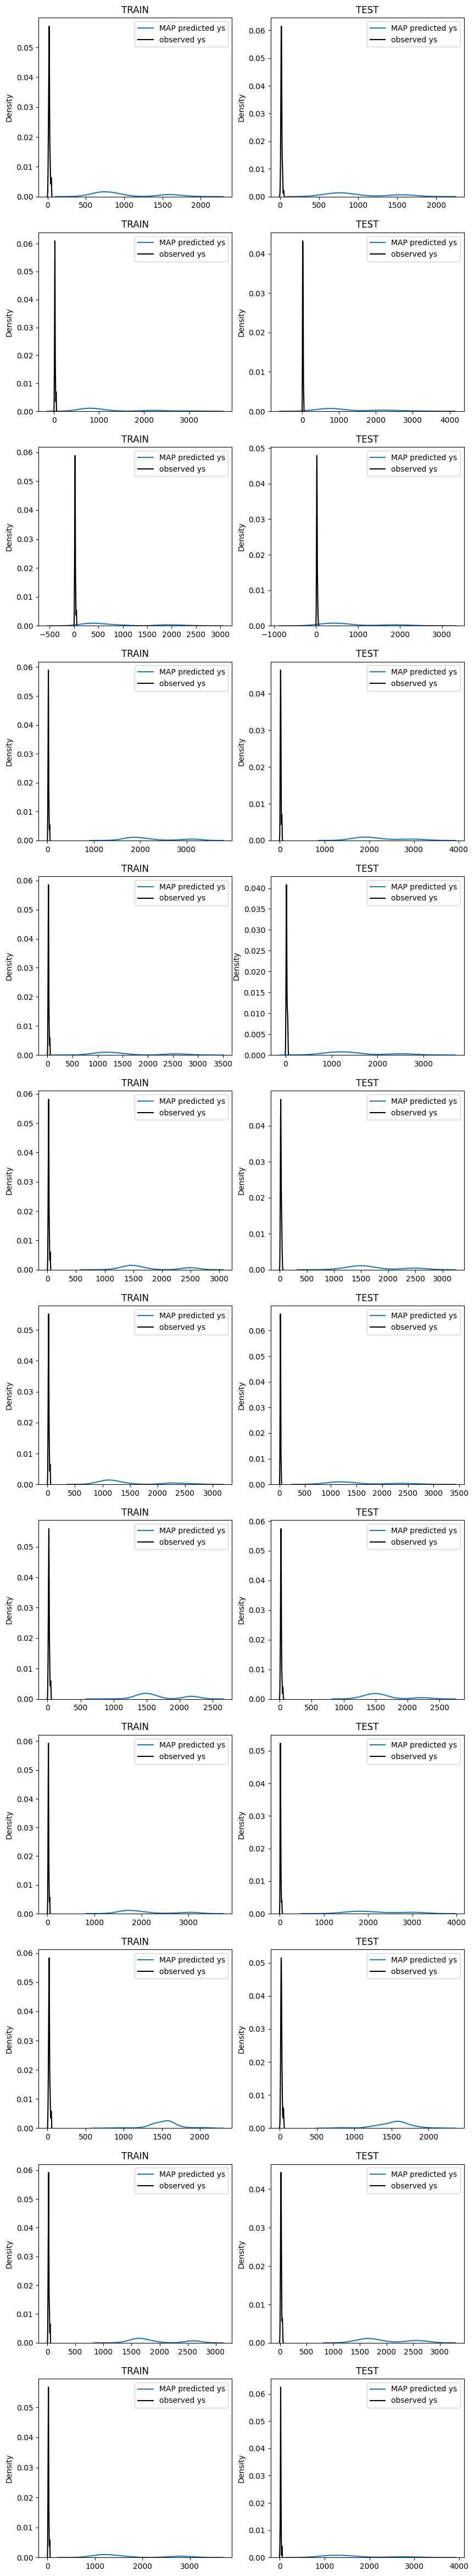

In [ ]:
key = jax.random.PRNGKey(SEED)
keys = jax.random.split(key, (len(models), 2))
fig, axs = plt.subplots(len(models), 2, figsize=(10, 5*len(models)))
for (key_tr, key_te), d, row in zip(keys, models, range(len(models))):
    model = bnns.model_configs.__dict__[d["model"]]
    guide = AutoDelta(model)
    params = d["svi_result"]["params"]
    #predictive = Predictive(model, guide=guide, params=params, return_sites=["y"], parallel=True, num_samples=10)
    dataset = UCIDataset(d["dataset"])
    split = load_standard_splits(True)[d["dataset"]][d["split"]]
    train_X = dataset.data[split["tr"]][:, :-1]
    train_y = dataset.data[split["tr"]][:, -1]
    test_X = dataset.data[split["te"]][:, :-1]
    test_y = dataset.data[split["te"]][:, -1]

    # Get posterior sample
    posterior_sample_predictive = Predictive(guide, params=params, num_samples=1)
    posterior_samples = posterior_sample_predictive(key_tr, X=train_X, y=train_y, D_Y=1)

    # Get Y sample
    predictive = Predictive(model, posterior_samples, params=params, return_sites=["y"], batch_ndims=1, num_samples=1)
    predictive_ys = predictive(key_tr, X=train_X, y=None, D_Y=1)["y"]
    sns.kdeplot(predictive_ys.flatten(), ax=axs[row, 0], label="MAP predicted ys")
    sns.kdeplot(train_y, ax=axs[row, 0], label="observed ys", color="black")
    axs[row, 0].legend()
    axs[row, 0].set_title(f"TRAIN")
    # az_data = az.from_dict(posterior_samples=params, constant_data={"X": train_X}, posterior_predictive={"y": predictive_ys}, observed_data={"y": train_y})
    # az.plot_ppc(az_data, data_pairs={"y": "y"}, ax=axs[row, 0], kind="kde")

    predictive_ys = predictive(key_te, X=test_X, y=None, D_Y=1)["y"]
    sns.kdeplot(predictive_ys.flatten(), ax=axs[row, 1], label="MAP predicted ys")
    sns.kdeplot(test_y, ax=axs[row, 1], label="observed ys", color="black")
    axs[row, 1].legend()
    axs[row, 1].set_title(f"TEST")
    # az_data = az.from_dict(posterior_samples=params, constant_data={"X": test_X}, posterior_predictive={"y": predictive_ys}, observed_data={"y": test_y})
    # az.plot_ppc(az_data, data_pairs={"y": "y"}, ax=axs[row, 1], kind="kde")